In [14]:
# ==============================================================
# Global Imports
# ==============================================================

import os, cv2, shutil, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import clip

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    log_loss,
    confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight

from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2


In [23]:
# ==============================================================
# Color Histogram Baseline
# ==============================================================

dataset_folder = "data/dataset_train/dataset_train"
image_paths = load_image_paths(dataset_folder)

color_features = np.array([extract_color_histogram(p) for p in image_paths])

np.save("color_features.npy", color_features)
np.save("color_image_paths.npy", np.array(image_paths))

print("Saved color histogram features:", len(image_paths))


Saved color histogram features: 14876


In [8]:
# ==============================================================
# Merge Style Folders
# ==============================================================

merge_map = {
    "modern": "modern_contemporary",
    "contemporary": "modern_contemporary",
    "transitional": "modern_contemporary",
    "asian": "modern_contemporary",
    "scandinavian": "modern_contemporary",
    "mid-century-modern": "modern_contemporary",

    "rustic": "rustic_farmhouse",
    "farmhouse": "rustic_farmhouse",
    "craftsman": "rustic_farmhouse",
    "french-country": "rustic_farmhouse",

    "industrial": "industrial",

    "coastal": "coastal_natural",
    "mediterranean": "coastal_natural",

    "traditional": "classic_traditional",
    "victorian": "classic_traditional",
    "shabby-chic-style": "classic_traditional",

    "eclectic": "eclectic_other",
    "southwestern": "eclectic_other",
    "tropical": "eclectic_other"
}

def merge_dataset(src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)
    counts = defaultdict(int)

    for old_style, new_group in merge_map.items():
        src = os.path.join(src_root, old_style)
        dst = os.path.join(dst_root, new_group)
        os.makedirs(dst, exist_ok=True)

        if not os.path.exists(src):
            print("Skipping missing folder:", src)
            continue

        for fname in os.listdir(src):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                shutil.copy2(os.path.join(src, fname), os.path.join(dst, fname))
                counts[new_group] += 1

    return counts


for split in ["train", "test"]:
    src = f"data/dataset_{split}/dataset_{split}"
    dst = f"data/dataset_{split}_merged"
    result = merge_dataset(src, dst)
    print(f"\nMerged {split} →", result)



Merged train → defaultdict(<class 'int'>, {'modern_contemporary': 4722, 'rustic_farmhouse': 3140, 'industrial': 764, 'coastal_natural': 1583, 'classic_traditional': 2314, 'eclectic_other': 2353})

Merged test → defaultdict(<class 'int'>, {'modern_contemporary': 1183, 'rustic_farmhouse': 788, 'industrial': 192, 'coastal_natural': 397, 'classic_traditional': 580, 'eclectic_other': 589})


In [9]:
# ==============================================================
# Train Style CNN
# ==============================================================

train_dir = "data/dataset_train_merged"
val_dir   = "data/dataset_test_merged"

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
).flow_from_directory(train_dir, target_size=(224,224))

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(224,224), shuffle=False
)

base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
for layer in base.layers[:-20]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(base.input, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("style_cnn_best.h5", save_best_only=True)
    ]
)

model.save("style_cnn_final.h5")
print("Saved: style_cnn_final.h5")



Found 14876 images belonging to 6 classes.
Found 3729 images belonging to 6 classes.


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3470 - loss: 1.6821

465/465 ━━━━━━━━━━━━━━━━━━━━ 158s 329ms/step - accuracy: 0.3471 - loss: 1.6819 - val_accuracy: 0.3288 - val_loss: 2.3140
Epoch 2/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4596 - loss: 1.3931

465/465 ━━━━━━━━━━━━━━━━━━━━ 161s 345ms/step - accuracy: 0.4596 - loss: 1.3931 - val_accuracy: 0.3757 - val_loss: 2.0705
Epoch 3/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4956 - loss: 1.3161

465/465 ━━━━━━━━━━━━━━━━━━━━ 170s 365ms/step - accuracy: 0.4956 - loss: 1.3161 - val_accuracy: 0.4277 - val_loss: 1.6344
Epoch 4/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5127 - loss: 1.2562

465/465 ━━━━━━━━━━━━━━━━━━━━ 178s 382ms/step - accuracy: 0.5127 - loss: 1.2562 - val_accuracy: 0.4218 - val_loss: 1.6033
Epoch 5/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5437 - loss: 1.1885

465/465 ━━━━━━━━━━━━━━━━━━━━ 184s 395ms/step - accuracy: 0.5437 - loss: 1.1886 - val_accuracy: 0.4318 - val_loss: 1.5729
Epoch 6/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5699 - loss: 1.1318

465/465 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.5699 - loss: 1.1318 - val_accuracy: 0.4776 - val_loss: 1.4323
Epoch 7/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5807 - loss: 1.0992

465/465 ━━━━━━━━━━━━━━━━━━━━ 157s 338ms/step - accuracy: 0.5807 - loss: 1.0992 - val_accuracy: 0.4932 - val_loss: 1.4236
Epoch 8/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 162s 349ms/step - accuracy: 0.6106 - loss: 1.0341 - val_accuracy: 0.4878 - val_loss: 1.4647
Epoch 9/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 172s 369ms/step - accuracy: 0.6303 - loss: 0.9899 - val_accuracy: 0.4827 - val_loss: 1.4554
Epoch 10/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 2953s 6s/step - accuracy: 0.6514 - loss: 0.9286 - val_accuracy: 0.4798 - val_loss: 1.5046
Epoch 11/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.6693 - loss: 0.8927 - val_accuracy: 0.4663 - val_loss: 1.6007
Epoch 12/15
465/465 ━━━━━━━━━━━━━━━━━━━━ 155s 332ms/step - accuracy: 0.6921 - loss: 0.8177 - val_accuracy: 0.4259 - val_loss: 1.9180


Saved: style_cnn_final.h5


In [10]:
# ==============================================================
# CLIP Room-Type Labeling
# ==============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

room_types = [
    "a photo of a kitchen",
    "a photo of a bedroom",
    "a photo of a bathroom",
    "a photo of a living room",
    "a photo of a dining room",
    "a photo of a home office"
]

text_tokens = clip.tokenize(room_types).to(device)

all_paths = load_image_paths("data/dataset_train/dataset_train")
labels = []

for path in tqdm(all_paths, desc="Labeling rooms"):
    try:
        img = preprocess_clip(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = clip_model.encode_image(img)
            txt_feat = clip_model.encode_text(text_tokens)
            probs = (img_feat @ txt_feat.T).softmax(dim=-1)
            idx = probs.argmax().item()
            room = room_types[idx].replace("a photo of a ", "")
    except:
        room = "unknown"

    labels.append((path, room))

df = pd.DataFrame(labels, columns=["image_path", "room_type"])
df.to_csv("roomtype_labels.csv", index=False)
print("Saved roomtype_labels.csv")


Labeling rooms: 100%|██████████| 14876/14876 [53:22<00:00,  4.64it/s]    

Saved roomtype_labels.csv


In [11]:
# ==============================================================
# Fast: Fine-tune (if needed) + Batched Embeddings + Batched Room Labels
# Runtime: ~10–20 minutes for 15k images
# ==============================================================

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array

import torch
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm import tqdm

# --------------------------------------------------------------
# 1. Load Style CNN & Prepare Batched TF Dataset
# --------------------------------------------------------------
style_model = tf.keras.models.load_model("style_cnn_best.h5")
style_embedding_model = Model(
    inputs=style_model.input,
    outputs=style_model.layers[-2].output
)

def build_tf_dataset(paths, batch_size=128):
    def load_and_preprocess(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = img / 255.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# --------------------------------------------------------------
# 2. Load Room-Type Dataset (if training is needed)
# --------------------------------------------------------------
data_dir = "data/roomtype_auto_clip_sorted"
room_types = ["kitchen", "bedroom", "bathroom", "living room", "dining room", "home office"]

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

model_file = "roomtype_resnet50_finetuned.pth"
device = "cpu"

# --------------------------------------------------------------
# 3. Load or Train Room Model
# --------------------------------------------------------------
room_model = models.resnet50(weights="IMAGENET1K_V2")
room_model.fc = torch.nn.Linear(room_model.fc.in_features, len(room_types))

if os.path.exists(model_file):
    print("Loading fine-tuned room classifier...")
    room_model.load_state_dict(torch.load(model_file, map_location=device))
else:
    print("Fine-tuning room classifier (fast mode)...")
    from torchvision.datasets import ImageFolder

    dataset = ImageFolder(data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    for p in room_model.parameters():
        p.requires_grad = False
    for p in room_model.fc.parameters():
        p.requires_grad = True

    room_model = room_model.to(device)
    room_model.train()

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(room_model.fc.parameters(), lr=1e-4)

    for epoch in range(5):
        losses = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = room_model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            losses += loss.item()
        print(f"Epoch {epoch+1}/5 - Loss {losses/len(loader):.4f}")

    torch.save(room_model.state_dict(), model_file)

room_model.eval().to(device)

# --------------------------------------------------------------
# 4. Load Image Paths
# --------------------------------------------------------------
def load_image_paths(folder):
    paths = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(os.path.join(root, f))
    return paths

dataset_folder = "data/dataset_train/dataset_train"
image_paths = load_image_paths(dataset_folder)
image_paths_np = np.array(image_paths)

print(f"Total images: {len(image_paths_np)}")

# --------------------------------------------------------------
# 5. Style Embeddings (Batched GPU)
# --------------------------------------------------------------
print("\n==== Generating STYLE embeddings (batched TF) ====\n")

tf_ds = build_tf_dataset(image_paths_np, batch_size=128)

style_embeddings_batches = []
for batch in tqdm(tf_ds, desc="Style Embeddings"):
    emb = style_embedding_model.predict(batch, verbose=0)
    style_embeddings_batches.append(emb)

style_embeddings = np.vstack(style_embeddings_batches)

# --------------------------------------------------------------
# 6. Room Labels (macOS-safe: NO DataLoader, NO multiprocessing)
# --------------------------------------------------------------
print("\n==== Predicting ROOM labels (macOS safe mode) ====\n")

room_model = room_model.cpu()
room_model.eval()

room_preds = np.zeros(len(image_paths_np), dtype=np.int32)

batch_size = 64
num_images = len(image_paths_np)

for start in tqdm(range(0, num_images, batch_size), desc="Room Labels"):
    end = start + batch_size
    batch_paths = image_paths_np[start:end]

    imgs = []
    for p in batch_paths:
        img = Image.open(p).convert("RGB")
        imgs.append(transform(img))

    batch = torch.stack(imgs)  # shape [B, C, H, W]

    with torch.no_grad():
        logits = room_model(batch)
        preds = logits.argmax(dim=1).numpy()

    room_preds[start:end] = preds

# --------------------------------------------------------------
# 7. Save Results
# --------------------------------------------------------------
np.save("style_embeddings.npy", style_embeddings)
np.save("room_labels.npy", room_preds)
np.save("image_paths.npy", image_paths_np)

print("\nDone! Saved embeddings, room labels, and image paths.")

Loading fine-tuned room classifier...
Total images: 14876

==== Generating STYLE embeddings (batched TF) ====



Style Embeddings: 100%|██████████| 117/117 [01:40<00:00,  1.16it/s]



==== Predicting ROOM labels (macOS safe mode) ====



Room Labels: 100%|██████████| 233/233 [25:21<00:00,  6.53s/it]


Done! Saved embeddings, room labels, and image paths.


In [17]:
# ==============================================================
# Functions needed for Similarity Search
# ==============================================================

# ---- 1. preprocess_tf (new version, no keras_image) ----
def preprocess_tf(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    return x

# ---- 2. Style embedding extraction ----
def get_style_embedding(path):
    x = preprocess_tf(path)
    emb = style_embedding_model.predict(x, verbose=0).flatten()
    return emb

# ---- 3. Room label prediction (uses your CPU room model) ----
def predict_room_label(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0)  # CPU version (no .to(device))
    with torch.no_grad():
        logits = room_model(x)
        idx = logits.argmax(dim=1).item()
    return idx, room_types[idx]


=== Query: blog_figures/validation_set_bedroom.jpg ===

Predicted room type: bedroom


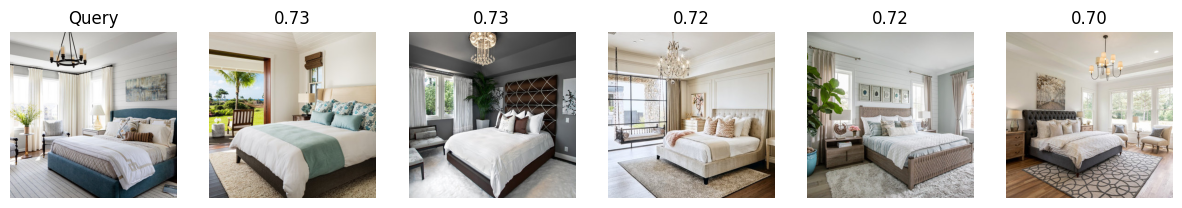


=== Query: blog_figures/validation_set_bathroom.jpg ===

Predicted room type: kitchen


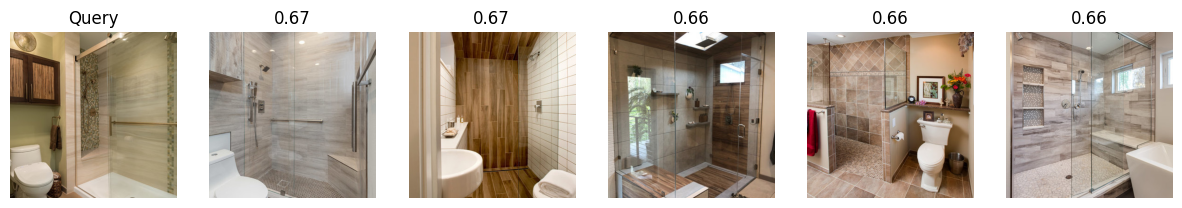


=== Query: blog_figures/my_bathroom.jpg ===

Predicted room type: kitchen


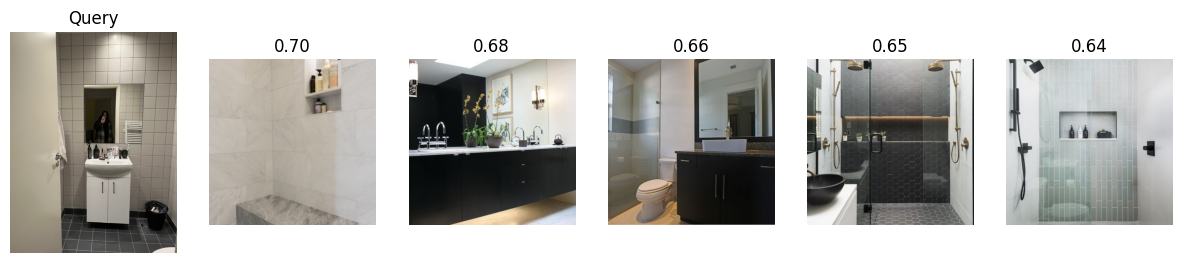


=== Query: blog_figures/my_bedroom.jpg ===

Predicted room type: bedroom


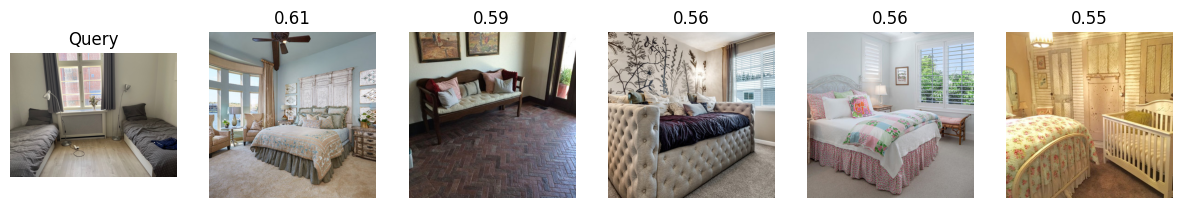

In [18]:
# ==============================================================
# Style Similarity Search
# ==============================================================

style_embeddings = np.load("style_embeddings.npy")
room_labels = np.load("room_labels.npy")
image_paths = np.load("image_paths.npy", allow_pickle=True)

def find_similar_images(query_path, top_k=5):
    q_room, room_name = predict_room_label(query_path)
    print("\nPredicted room type:", room_name)

    valid = np.where(room_labels == q_room)[0]
    if len(valid) == 0:
        print("No same-room images found.")
        return []

    q_emb = get_style_embedding(query_path)
    sims = cosine_similarity([q_emb], style_embeddings[valid])[0]

    idxs = np.argsort(sims)[::-1][:top_k]
    return [(image_paths[valid[i]], sims[i]) for i in idxs]


def show_results(query_path, results):
    plt.figure(figsize=(15,4))
    plt.subplot(1, len(results)+1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_path), cv2.COLOR_BGR2RGB))
    plt.title("Query")
    plt.axis("off")

    for i, (img_path, score) in enumerate(results, 2):
        plt.subplot(1, len(results)+1, i)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{score:.2f}")
        plt.axis("off")

    plt.show()


# ===== Queries =====

queries = [
    "blog_figures/validation_set_bedroom.jpg",
    "blog_figures/validation_set_bathroom.jpg",
    "blog_figures/my_bathroom.jpg",
    "blog_figures/my_bedroom.jpg"
]

for q in queries:
    print("\n=== Query:", q, "===")
    results = find_similar_images(q, top_k=5)
    show_results(q, results)



=== Histogram Query: blog_figures/validation_set_bedroom.jpg ===


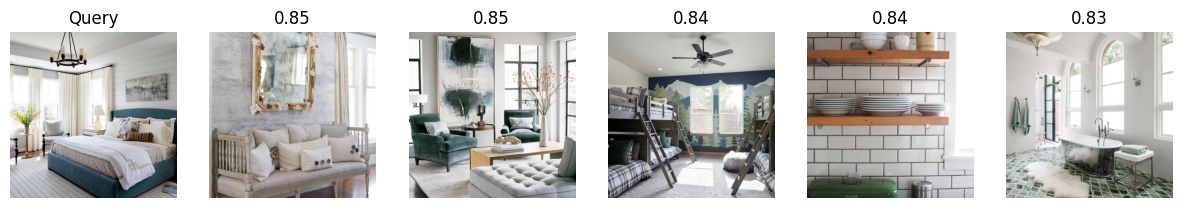


=== Histogram Query: blog_figures/validation_set_bathroom.jpg ===


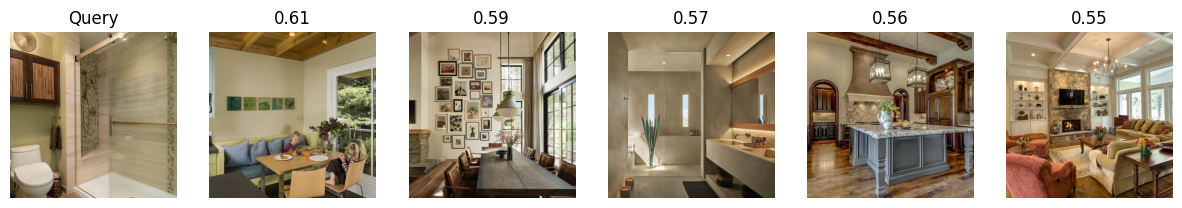


=== Histogram Query: blog_figures/my_bathroom.jpg ===


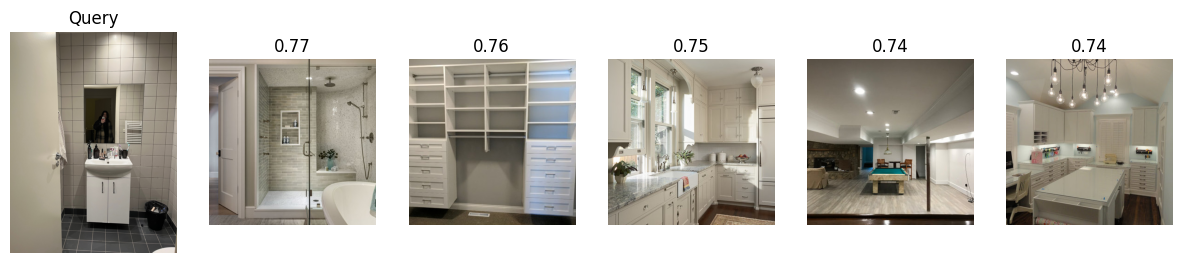


=== Histogram Query: blog_figures/my_bedroom.jpg ===


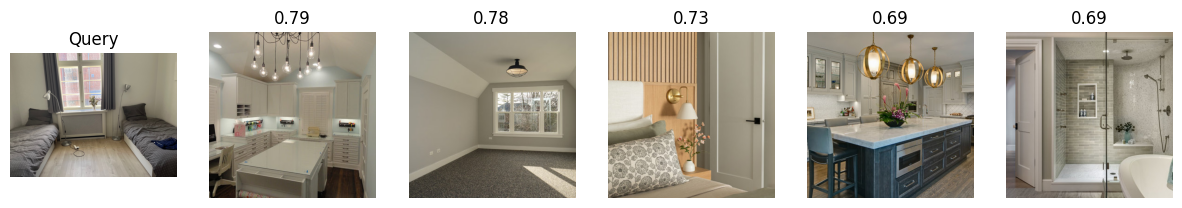

In [24]:
# ==============================================================
# Color Histogram Similarity Search
# ==============================================================

color_features = np.load("color_features.npy")
color_image_paths = np.load("color_image_paths.npy", allow_pickle=True)

def hist_find_similar(query_path, top_k=5):
    q = extract_color_histogram(query_path)
    sims = cosine_similarity([q], color_features)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return [(color_image_paths[i], sims[i]) for i in idxs]

# ===== Queries =====

queries = [
    "blog_figures/validation_set_bedroom.jpg",
    "blog_figures/validation_set_bathroom.jpg",
    "blog_figures/my_bathroom.jpg",
    "blog_figures/my_bedroom.jpg"
]

for q in queries:
    print("\n=== Histogram Query:", q, "===")
    results = hist_find_similar(q, top_k=5)
    show_results(q, results)



Evaluating Room Style CNN (Keras)


Found 3729 images belonging to 6 classes.


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step

Room Style CNN Accuracy: 49.32%
Room Style CNN Loss: 1.4236
                     precision    recall  f1-score  support
classic_traditional   0.507042  0.310345  0.385027    580.0
coastal_natural       0.411765  0.088161  0.145228    397.0
eclectic_other        0.519313  0.410866  0.458768    589.0
industrial            0.556701  0.281250  0.373702    192.0
modern_contemporary   0.553698  0.727811  0.628926   1183.0


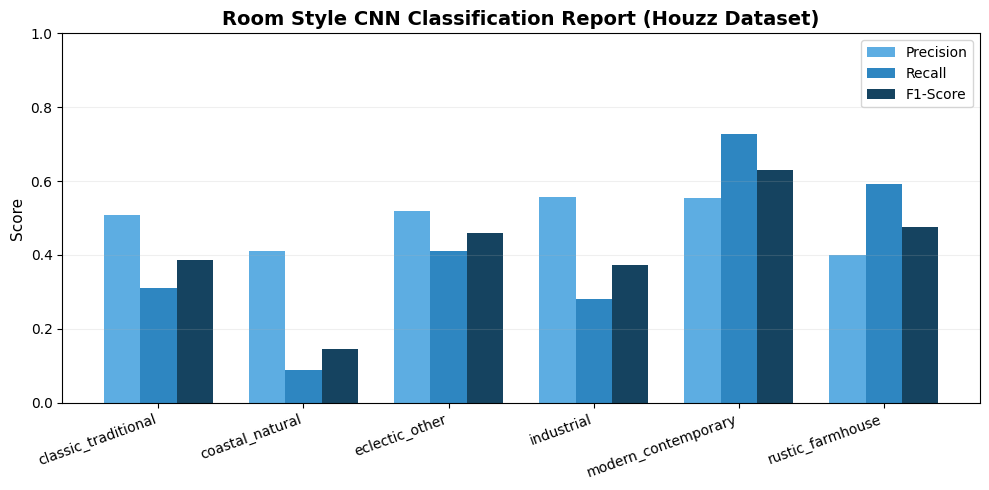


Evaluating Fine-Tuned Room-Type CNN (PyTorch)

Fine-Tuned Room-Type CNN Accuracy: 80.61%
Fine-Tuned Room-Type CNN Loss: 0.5796


/Users/sophie/Desktop/new final project/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [20]:
# --------------------------------------------------------------
#  Helper function to plot a classification report
# --------------------------------------------------------------
def plot_classification_report(report_df, title):
    """Display a clean bar chart for precision, recall, and F1."""
    report_df = report_df.iloc[:-3, :]  # drop avg rows

    plt.figure(figsize=(10, 5))
    x = np.arange(len(report_df))
    bar_width = 0.25

    plt.bar(x - bar_width, report_df['precision'], width=bar_width, label='Precision', color='#5DADE2')
    plt.bar(x, report_df['recall'], width=bar_width, label='Recall', color='#2E86C1')
    plt.bar(x + bar_width, report_df['f1-score'], width=bar_width, label='F1-Score', color='#154360')

    plt.xticks(x, report_df.index, rotation=20, ha='right', fontsize=10)
    plt.ylabel("Score", fontsize=11)
    plt.ylim(0, 1)
    plt.title(title, fontsize=14, weight='bold')
    plt.legend()
    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()


# ==============================================================
#  Evaluate Room Style CNN
# ==============================================================

print("\n==============================")
print("Evaluating Room Style CNN (Keras)")
print("==============================")

style_model = tf.keras.models.load_model("style_cnn_best.h5")

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "data/dataset_test_merged",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

y_true_style = val_gen.classes
y_pred_probs_style = style_model.predict(val_gen, verbose=1)
y_pred_style = np.argmax(y_pred_probs_style, axis=1)
class_labels = list(val_gen.class_indices.keys())

# Metrics
style_acc = accuracy_score(y_true_style, y_pred_style)
style_loss = log_loss(y_true_style, y_pred_probs_style)
print(f"\nRoom Style CNN Accuracy: {style_acc*100:.2f}%")
print(f"Room Style CNN Loss: {style_loss:.4f}")

style_report = classification_report(
    y_true_style,
    y_pred_style,
    target_names=class_labels,
    digits=3,
    output_dict=True
)

style_df = pd.DataFrame(style_report).transpose()
print(style_df.head())

plot_classification_report(
    style_df,
    title="Room Style CNN Classification Report (Houzz Dataset)"
)


# ==============================================================
#  Evaluate Fine-Tuned Room-Type CNN (PyTorch)
# ==============================================================

print("\n==============================")
print("Evaluating Fine-Tuned Room-Type CNN (PyTorch)")
print("==============================")

model_file = "roomtype_resnet50_finetuned.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

roomtype_model = models.resnet50(weights="IMAGENET1K_V2")
roomtype_model.fc = torch.nn.Linear(roomtype_model.fc.in_features, 6)
roomtype_model.load_state_dict(torch.load(model_file, map_location=device))
roomtype_model.to(device)
roomtype_model.eval()

data_dir = "data/roomtype_auto_clip_sorted"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

y_true_room, y_pred_room, y_probs_room = [], [], []
with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        outputs = roomtype_model(imgs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true_room.extend(labels.numpy())
        y_pred_room.extend(preds.cpu().numpy())
        y_probs_room.extend(probs.cpu().numpy())

# Metrics
roomtype_acc = accuracy_score(y_true_room, y_pred_room)
roomtype_loss = log_loss(y_true_room, y_probs_room)
print(f"\nFine-Tuned Room-Type CNN Accuracy: {roomtype_acc*100:.2f}%")
print(f"Fine-Tuned Room-Type CNN Loss: {roomtype_loss:.4f}")